In this script, we calclate global distribution of dust DRE by using the DREE-integration method introduced in Song et al. 2022 section 4 Eq.(6).

(1), DREE_k can be directly obtained from our size-resolved DREE dataset developed in this study. Our size-resolved DREE dataset is for 6 dust models. Here we calculate dust DRE for 'MeanSWRI-MeanLWRI-Spheroid' dust model as an example. 

(2), f_k depends on dust PSD. For simplicity, we use globally unifrom f_k in this example. Specifically, we use f_k derived based on globally averaged dust PSD from Kok et al. 2017. The derivation of f_k is shown in the script named 'f_k.ipynb'

In the case that dust PSD varies in space, f_k should also varies in space.

(3), In this example, DAOD is from CALIOP-based DAOD retrieval for 2020. (Note, even though size-resolved DREE dataset is derived based on data from 2007 to 2010. We can use this dataset to calculate dust DRE for other years. See discussion in Song et al. 2022 section 4.2).

The CALIOP-based DAOD retrieval from 2007 to 2020 is developed in Song et al. 2021 ACP. The DAOD climatology dataset is availabel in 'https://drive.google.com/drive/folders/1aQVupe7govPwR6qmsqUbR4fJQsp1DBCX?usp=sharing'.


References:

Song, Q., Zhang, Z., Yu, H., Ginoux, P., and Shen, J.: Global dust optical depth climatology derived from CALIOP and MODIS aerosol retrievals on decadal timescales: regional and interannual variability, Atmos. Chem. Phys., 21, 13369–13395, https://doi.org/10.5194/acp-21-13369-2021, 2021.



In [1]:
#----------
# Colab does not have basemap package
# This cell is to manually install basemap package to google colab
# Note, we need to 'Restart Runtime' after we install the package.
#----------

!pip install basemap

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from netCDF4 import Dataset
from scipy import stats
from mpl_toolkits.basemap import Basemap  #need to install manually by using '!pip install basemap'
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator

In [3]:
#----------
# This cell is to mount google colab to user's google drive. Then this code can access data in user's google drive
# User should download or prepare (1) size-resolved DREE dataset, (2)f_k and (3) DAOD dataset in advance and put it in user's google drive for this code to read.
# (1) The size-resolved DREE dataset is provided in this study. Please check 'Data Availability' in Song et al. 2022.
# (2) The f_k data can be generated by 'f_k.ipynb' for any dust PSD.
# (3) The CALIOP-based and MODIS-based DAOD climatology is provided by Song et al. 2021 (Please see the Reference above). 
#     User can use their own favorite DAOD product (from satellite retrieval or model simulation) and interpolate their DAOD on 5-deg (longitude)x 2-deg (latitude) grid.
#----------
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#----------
# Read Size-resolved DREE dataset developed in this study.
# We developed size-resolved DREE for six dust models (see Table 1 in the paper Song et al. 2022) in SW and LW respectively.
# Here we only calculate MeanSWRI-MeanLWRI-Spheroid dust model as an example. In fact, dust DRE can be calculated for 6 dust models listed in Table 1
#----------

#Users can change the data_dir path to acess Size-Resolved DREE Dataset in user's google drive.
data_dir = '../Data/'
dreesw_meanri_spheroid_data = Dataset(data_dir+'GlobalClearSky-MonthlyMean-SizeResolved-DustDREE-MeanSWRI-Sphere-20072010.nc')
#dreelw_meanri_spheroid_data = Dataset(data_dir+'GlobalClearSky-MonthlyMean-SizeResolved-DustDREE-MeanLWRI-DubovikSpheroid-20072010.nc')
print(dreesw_meanri_spheroid_data)

dreesw_meanri_spheroid_toa = np.array(dreesw_meanri_spheroid_data.variables['DREE_TOA'][:])
#print(dreesw_meanri_spheroid_toa)
#dreesw_meanri_spheroid_suf = np.array(dreesw_meanri_spheroid_data.variables['DREE_SUF'][:])
#dreelw_meanri_spheroid_toa = np.array(dreelw_meanri_spheroid_data.variables['DREE_TOA'][:])
#dreelw_meanri_spheroid_suf = np.array(dreelw_meanri_spheroid_data.variables['DREE_SUF'][:])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): sizebin_edge(11), sizebin_center(10), month(12), lat(90), lon(72)
    variables(dimensions): float32 sizebin_edge(sizebin_edge), float32 sizebin_center(sizebin_center), float32 month(month), float32 lat(lat), float32 lon(lon), float32 DREE_TOA(sizebin_center, month, lat, lon), float32 DREE_SUF(sizebin_center, month, lat, lon), float32 DREE_TOA_std(sizebin_center, month, lat, lon), float32 DREE_SUF_std(sizebin_center, month, lat, lon)
    groups: 


In [6]:
dreesw_meanri_spheroid_toa[:,6,52,34]

array([-53.72786 , -29.672419, -22.686268, -32.73414 , -17.875599,
        -5.809365,   8.428296,  24.974424,  42.53248 ,  61.69918 ],
      dtype=float32)

In [6]:
#----------
# Read f_k (percentage contribution of each size bin to total DAOD)
# Note, f_k depends on dust PSD. Users can calculate f_k for any dust PSD by using the script 'f_k.ipynb'
# In this example, for simplicigy, we use f_k derived based on dust PSD suggested by Kok et al. 2017, which is globally uniform.
#----------

# Upload file from user's local file system
# Here need to upload the '.txt' file generated in 'f_k.ipynb'. The '.txt' file is alreay downloaded to user's local file system in 'f_k.ipynb'
from google.colab import files
uploaded = files.upload()

# Read the '.txt' file that is uploaded above. 
faod = np.loadtxt('Faod_kok17PSD_2Shape_3RI.txt',skiprows=1)
faod_maxri_sphere = faod[:,0]
faod_meanri_sphere = faod[:,1]
faod_minri_sphere = faod[:,2]
faod_maxri_spheroid = faod[:,3]
faod_meanri_spheroid = faod[:,4]
faod_minri_spheroid = faod[:,5]

ModuleNotFoundError: No module named 'google'

In [7]:
#----------
#Read CALIOP-based DAOD of each pixels (Song et al. 2021 ACP)
#CALIOP-based DAOD climatology is available at 'https://drive.google.com/drive/folders/1aQVupe7govPwR6qmsqUbR4fJQsp1DBCX?usp=sharing'
#----------

#Users can change the daod_dir path to acess DAOD Climatology Dataset in user's google drive.
daod_dir = '/content/drive/My Drive/Qianqian/Global_Dust_Climatology_Data_CALIOP/CALIOPGlobalDustClimatology/Version2_GlobalClearSkyDustClimatology2020andAfter_AccountingForTopography/'
daod_fname = daod_dir + 'GlobalClearSkyMeanDustClimatology_CALIOP2020Monthly.nc'
daod_database= Dataset(daod_fname)
year = np.array(daod_database.variables['year'][:])
lat = np.array(daod_database.variables['lat'][:])
lon = np.array(daod_database.variables['lon'][:])
daod = np.array(daod_database.variables['clr_hlc_dustaod'][:])[0,:,:,:]
daod[daod == -9.9] = np.nan
lat_mask = (lat<-60) | (lat>60)
daod[:,lat_mask,:]=0 
print(daod.shape)

FileNotFoundError: [Errno 2] No such file or directory: b'/content/drive/My Drive/Qianqian/Global_Dust_Climatology_Data_CALIOP/CALIOPGlobalDustClimatology/Version2_GlobalClearSkyDustClimatology2020andAfter_AccountingForTopography/GlobalClearSkyMeanDustClimatology_CALIOP2020Monthly.nc'

In [11]:
#----------
# Calculate dust DRE with DREE-integration method introduced in Song et al. 2022 Eq.(6)
# Dust DRE Dimension: (12 month, 90 latitude, 72 longitude). Unit: (W/m^2)
#----------

dresw_meanri_spheroid_toa = np.zeros((12,90,72)) # DRE_SW at TOA for MeanRI-Spheroid dust model 
dresw_meanri_spheroid_suf = np.zeros((12,90,72)) # DRE_SW at Surface for MeanRI-Spheroid dust model

drelw_meanri_spheroid_toa = np.zeros((12,90,72)) # DRE_LW at TOA for MeanRI-Spheroid dust model
drelw_meanri_spheroid_suf = np.zeros((12,90,72)) # DRE_LW at Surface for MeanRI-Spheroid dust model


for imn in range(12):
  for ilat in range(90):
    for ilon in range(72):
      dresw_meanri_spheroid_toa[imn,ilat,ilon] = np.sum(dreesw_meanri_spheroid_toa[:,imn,ilat,ilon]*faod_meanri_spheroid*daod[imn,ilat,ilon])
      dresw_meanri_spheroid_suf[imn,ilat,ilon] = np.sum(dreesw_meanri_spheroid_suf[:,imn,ilat,ilon]*faod_meanri_spheroid*daod[imn,ilat,ilon])
      drelw_meanri_spheroid_toa[imn,ilat,ilon] = np.sum(dreelw_meanri_spheroid_toa[:,imn,ilat,ilon]*faod_meanri_spheroid*daod[imn,ilat,ilon])
      drelw_meanri_spheroid_suf[imn,ilat,ilon] = np.sum(dreelw_meanri_spheroid_suf[:,imn,ilat,ilon]*faod_meanri_spheroid*daod[imn,ilat,ilon])


In [12]:
#define lon lat boundaries for map plot
lon_bds = np.arange(-180,181,5)  # longitude grid boundaries (CALIOP DATA)
lat_bds = np.arange(-90,91,2)   # latitude grid boundaries (CALIOP DATA)

bounds_swdre = np.arange(-5,5.1,0.1)
norm_swdre  = colors.BoundaryNorm(boundaries = bounds_swdre, ncolors = 256)

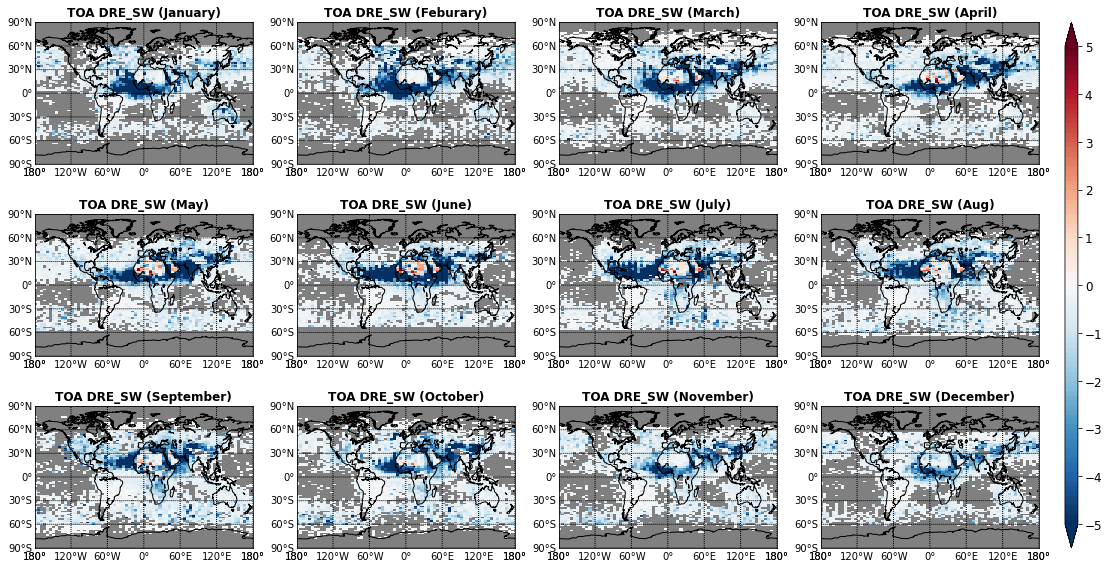

In [13]:
#----------
#Global Map of Monthly Mean DRE_SW
#----------

fig,ax = plt.subplots(3,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)
Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])

imn=0
axis=ax[0,0]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=1
axis=ax[0,1]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=2
axis=ax[0,2]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=3
axis=ax[0,3]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

imn=4
axis=ax[1,0]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=5
axis=ax[1,1]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=6
axis=ax[1,2]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=7
axis=ax[1,3]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

imn=8
axis=ax[2,0]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=9
axis=ax[2,1]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=10
axis=ax[2,2]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=11
axis=ax[2,3]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,dresw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_SW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


cmap=plt.get_cmap('RdBu_r')
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,3].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2,3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]))
axcb.ax.tick_params(labelsize=12)

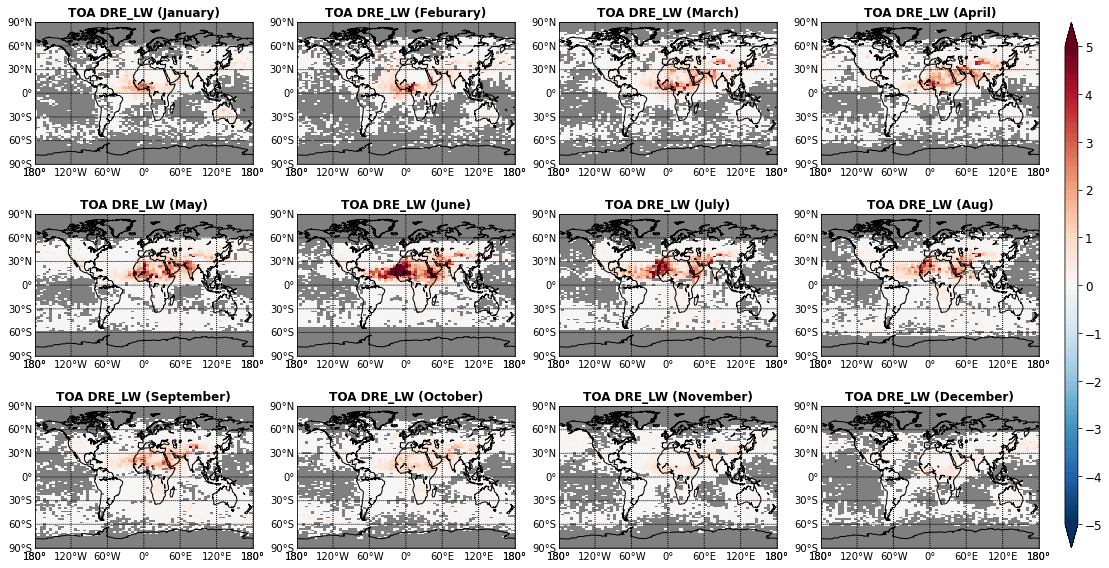

In [14]:
#----------
#Global Map of Monthly Mean DRE_LW
#----------

fig,ax = plt.subplots(3,4,figsize=(18,10))
fig.patch.set_facecolor('white')
map = Basemap(llcrnrlon = -180, llcrnrlat = -90, urcrnrlon = 180, urcrnrlat = 90)
Lon,Lat = map(lon_bds,lat_bds)   
aspect=1.3
mns=np.array(['January','Feburary','March','April','May','June','July','Aug','September','October','November','December'])


imn=0
axis=ax[0,0]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=1
axis=ax[0,1]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=2
axis=ax[0,2]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=3
axis=ax[0,3]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

imn=4
axis=ax[1,0]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=5
axis=ax[1,1]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=6
axis=ax[1,2]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=7
axis=ax[1,3]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)

imn=8
axis=ax[2,0]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=9
axis=ax[2,1]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=10
axis=ax[2,2]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


imn=11
axis=ax[2,3]
map.drawcoastlines(ax=axis)
map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],ax=axis,fontsize=10)
map.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],ax=axis,fontsize=10)
cs00=map.pcolormesh(Lon,Lat,drelw_meanri_spheroid_toa[imn,:,:],cmap=plt.get_cmap('RdBu_r'),norm=norm_swdre,ax=axis)
axis.set_title('TOA DRE_LW ({:s})'.format(mns[imn]),fontsize=12,fontweight='bold')
axis.set_aspect(aspect)


cmap=plt.get_cmap('RdBu_r')
cmap.set_bad(color='grey')

#****Colorbar
# getting the lower left (x0,y0) and upper right (x1,y1) corners:
[[x00,y00],[x01,y01]] = ax[0,3].get_position().get_points()
[[x10,y10],[x11,y11]] = ax[2,3].get_position().get_points()
pad = 0.02; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width, y01-y10])
axcb = fig.colorbar(cs00, cax=cbar_ax,extend='both',ticks=np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5]))
axcb.ax.tick_params(labelsize=12)

In [ ]:
#----------
#For each month: calculate globally-averaged dust DRE weighted by surface area of each grid cell
#----------

def deg2rad(deg):
    rad = deg*np.pi/180
    return(rad)
llon,llat = np.meshgrid(lon,lat)

dresw_toa_areweighted_gm = np.zeros(12)
dresw_suf_areweighted_gm = np.zeros(12)
drelw_toa_areweighted_gm = np.zeros(12)
drelw_suf_areweighted_gm = np.zeros(12)

for imn in range(12):
  dresw_toa_areweighted_gm[imn] = np.average(dresw_meanri_spheroid_toa[imn,:,:],weights=np.cos(deg2rad(llat)))
  dresw_suf_areweighted_gm[imn] = np.average(dresw_meanri_spheroid_suf[imn,:,:],weights=np.cos(deg2rad(llat)))
  drelw_toa_areweighted_gm[imn] = np.average(drelw_meanri_spheroid_toa[imn,:,:],weights=np.cos(deg2rad(llat)))
  drelw_suf_areweighted_gm[imn] = np.average(drelw_meanri_spheroid_suf[imn,:,:],weights=np.cos(deg2rad(llat)))